# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Import modules

Make sure you have the latest version of GraphLab Create (>= 1.7)

In [1]:
import numpy as np
import pandas as pd

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv',dtype=dtype_dict)

If you’re using Python: to do the matrix operations required to perform a gradient descent we will be using the popular python library `numpy` which is a computational library specialized for operations on arrays. For students unfamiliar with numpy we have created a numpy tutorial (see useful resources). It is common to import numpy under the name ‘np’ for short, to do this execute: `import numpy as np`

# Import useful functions from previous notebook

Next, from Module 2, copy and paste the `get_numpy_data` function (or equivalent) that takes a dataframe, a list of features (e.g. [`sqft_living`, `bedrooms`]), to be used as inputs, and a name of the output (e.g. `price`). This function returns a `feature_matrix` (2D array) consisting of first a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It alsos return an `output_array` which is an array of the values of the output in the data set (e.g. `price`).

In [4]:
def get_numpy_data(data_frame, features, output):
    data_frame = data_frame.assign(constant = 1)
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features
    feature_df = data_frame.loc[:, features]
    # the following line will convert the features_df into a numpy matrix:
    feature_matrix = feature_df.values
    # assign the column of data_frame associated with the output to the SArray output_sarray
    output_df = data_frame.loc[:, output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_df.values
    
    return(feature_matrix, output_array)

Similarly, copy and paste the `predict_output` function (or equivalent) from Module 2. This function accepts a 2D array `feature_matrix` and a 1D array `weights` and return a 1D array `predictions`.

In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [9]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    if feature_is_constant:
        derivative = 2 * np.sum(errors)
    else:
        derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    
    return derivative

To test your feature derivartive run the following:

In [10]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20.)
print('')

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print(np.sum(errors)*2.)

-56554166815950.0
-56554166815950.0

-22446749330.0
-22446749330.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the ‘step size’. We stop when we are ‘sufficiently close’ to the optimum. Unlike in Module 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, write a gradient descent function using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria. The function will take the following parameters:

* 2D feature matrix
* array of output values
* initial weights
* step size
* L2 penalty
* maximum number of iterations

To make your job easier, we provide a skeleton in Python:

In [11]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        errors = predictions - output

        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, False)

            # subtract the step size times the derivative from the current weight
            weights[i] -= derivative * step_size
            
    print('Done with gradient descent at iteration ', iteration)
    print('Learned weights = ', str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature.

* features: `sqft_living`
* output: `price`

Split the dataset into training set and test set. If you are using GraphLab Create, call `train_data,test_data = sales.random_split(.8,seed=0)`. Otherwise, please download the csv files from the download section.

In [12]:
train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)

Convert the training set and test set using the `get_numpy_data` function.e.g. in Python:

In [13]:
simple_features = ['sqft_living']
my_output = 'price'

(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm to learn the weights of the simple model (described above). Use the following parameters:

* step_size = 1e-12
* max_iterations = 1000
* initial_weights = all zeros

Store the learned weights as `simple_weights_0_penalty`. We'll use them later.

In [14]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

l2_penalty = 0.0

In [15]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5394267213533688.0
Iteration = 3
Cost function =  4023237736286403.5
Iteration = 4
Cost function =  3101256183295487.0
Iteration = 5
Cost function =  2481247643601012.0
Iteration = 6
Cost function =  2064308076801447.0
Iteration = 7
Cost function =  1783927096156441.0
Iteration = 8
Cost function =  1595378201854742.0
Iteration = 9
Cost function =  1468583989698184.0
Iteration = 10
Cost function =  1383318190090051.0
Iteration = 20
Cost function =  1211562139024524.5
Iteration = 30
Cost function =  1208313761205656.5
Iteration = 40
Cost function =  1208252324779675.5
Iteration = 50
Cost function =  1208251162139724.5
Iteration = 60
Cost function =  1208251139442068.0
Iteration = 70
Cost function =  1208251138303840.8
Iteration = 80
Cost function =  1208251137573361.5
Iteration = 90
Cost function =  1208251136850594.0
Iteration = 100
Cost function =  1208251136

Next, let’s consider high regularization. Set the `l2_penalty` to `1e+11` and run your ridge regression to learn the weights of the simple model. Use the same parameters as above. Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [16]:
l2_penalty = 1e+11

simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5618303898910948.0
Iteration = 3
Cost function =  4920613278301801.0
Iteration = 4
Cost function =  4652381942678799.0
Iteration = 5
Cost function =  4549258764034560.0
Iteration = 6
Cost function =  4509612390884944.0
Iteration = 7
Cost function =  4494370050276983.0
Iteration = 8
Cost function =  4488509984023467.0
Iteration = 9
Cost function =  4486256988524010.0
Iteration = 10
Cost function =  4485390752666540.0
Iteration = 20
Cost function =  4484848868025912.0
Iteration = 30
Cost function =  4484847880470641.0
Iteration = 40
Cost function =  4484846931073274.5
Iteration = 50
Cost function =  4484845981678999.0
Iteration = 60
Cost function =  4484845032285122.0
Iteration = 70
Cost function =  4484844082891643.0
Iteration = 80
Cost function =  4484843133498564.0
Iteration = 90
Cost function =  4484842184105883.0
Iteration = 100
Cost function = 

If you have access to matplotlib, the following piece of code will plot the two learned models. (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

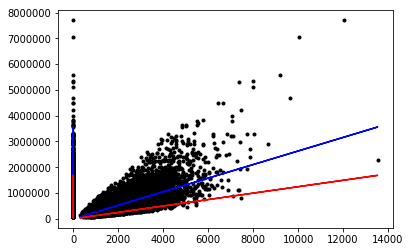

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [18]:
from decimal import Decimal

In [19]:
errors_1 = predict_output(simple_test_feature_matrix, initial_weights) - test_output
rss_1 = np.dot(errors_1, errors_1)
'%.2E' % rss_1

'1.78E+15'

In [20]:
errors_2 = predict_output(simple_test_feature_matrix, simple_weights_0_penalty) - test_output
rss_2 = np.dot(errors_2, errors_2)
'%.2E' % rss_2

'2.76E+14'

In [21]:
errors_3 = predict_output(simple_test_feature_matrix, simple_weights_high_penalty) - test_output
rss_3 = np.dot(errors_3, errors_3)
'%.2E' % rss_3

'6.95E+14'

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?

In [22]:
print(round(simple_weights_0_penalty[1], 1))
print(round(simple_weights_high_penalty[1], 1))

263.0
124.6


2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?

No regularization

3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 

In [23]:
print('%.2E' % rss_1)
print('%.2E' % rss_2)
print('%.2E' % rss_3)

1.78E+15
2.76E+14
6.95E+14


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [24]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'

(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [25]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [26]:
l2_penalty = 0.0

multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4056752332045943.0
Iteration = 3
Cost function =  2529565114525309.5
Iteration = 4
Cost function =  1838556694300506.8
Iteration = 5
Cost function =  1525675575150296.5
Iteration = 6
Cost function =  1383789498571783.5
Iteration = 7
Cost function =  1319232606146273.8
Iteration = 8
Cost function =  1289648871879140.5
Iteration = 9
Cost function =  1275884723913737.0
Iteration = 10
Cost function =  1269278807397619.5
Iteration = 20
Cost function =  1257812386017016.2
Iteration = 30
Cost function =  1251954570861556.5
Iteration = 40
Cost function =  1246755422656426.0
Iteration = 50
Cost function =  1242139508166548.5
Iteration = 60
Cost function =  1238041400480994.0
Iteration = 70
Cost function =  1234403012742170.8
Iteration = 80
Cost function =  1231172774196731.5
Iteration = 90
Cost function =  1228304899227735.5
Iteration = 100
Cost function =  1225758738

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [27]:
l2_penalty = 1e+11

multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4460489790922031.0
Iteration = 3
Cost function =  3796674469325301.0
Iteration = 4
Cost function =  3648319530880128.0
Iteration = 5
Cost function =  3615091103648369.0
Iteration = 6
Cost function =  3607602742943372.5
Iteration = 7
Cost function =  3605886322588678.0
Iteration = 8
Cost function =  3605474874959446.0
Iteration = 9
Cost function =  3605365168191212.0
Iteration = 10
Cost function =  3605329402609966.0
Iteration = 20
Cost function =  3605294281447482.5
Iteration = 30
Cost function =  3605293537691883.0
Iteration = 40
Cost function =  3605293083174690.0
Iteration = 50
Cost function =  3605292631531144.0
Iteration = 60
Cost function =  3605292179916288.0
Iteration = 70
Cost function =  3605291728301859.0
Iteration = 80
Cost function =  3605291276687576.0
Iteration = 90
Cost function =  3605290825073434.5
Iteration = 100
Cost function = 

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [28]:
def calculate_test_rss(test_feature_matrix, test_output, weights):
    errors = predict_output(test_feature_matrix, weights) - test_output
    rss = np.dot(errors, errors)
    return rss

In [29]:
rss_all_zero = calculate_test_rss(test_feature_matrix, test_output, initial_weights)

In [30]:
rss_0_penalty = calculate_test_rss(test_feature_matrix, test_output, multiple_weights_0_penalty)

In [31]:
rss_high_penalty = calculate_test_rss(test_feature_matrix, test_output, multiple_weights_high_penalty)

In [32]:
'%.2E' % round(max(rss_all_zero, rss_0_penalty, rss_high_penalty), 2)

'1.78E+15'

Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [33]:
error_index_0_no_penalty = predict_output(test_feature_matrix[0, :], multiple_weights_0_penalty) - test_output[0]
'%.2E' % error_index_0_no_penalty

'7.75E+04'

In [34]:
error_index_0_high_penalty = predict_output(test_feature_matrix[0, :], multiple_weights_high_penalty) - test_output[0]
'%.2E' % error_index_0_high_penalty

'-3.95E+04'

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?

In [35]:
print(round(multiple_weights_0_penalty[1], 1))
print(round(multiple_weights_high_penalty[1], 1))

243.1
91.5


2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 

In [36]:
print('%.2E' % rss_all_zero)
print('%.2E' % rss_0_penalty)
print('%.2E' % rss_high_penalty)

1.78E+15
2.74E+14
5.00E+14


3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?

`high regularization`